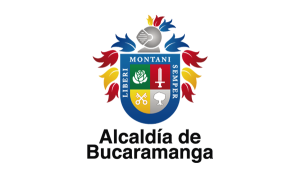

## Secretaría de Salud y Ambiente
---







<a href="https://colab.research.google.com/github/JotaRodriguez94/Forecasting_COVID_BGA/blob/main/MODELS_ML_DL_COVID-19_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

## Implementación y ajuste de modelos ML y DL para la predicción de casos COVID-19 en la ciudad de Bucaramanga.

In [1]:
#@title Importar dependencias
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

# download the code
!git clone -q https://github.com/JotaRodriguez94/Forecasting_COVID_BGA.git
# Uncomment this block to install necessary dependencies.
#!pip install -q statsmodels
!pip install -q xgboost
!pip install -q hyperopt
!pip install -U -q keras-tuner

import gc
import tqdm
import shutil
import IPython
import imageio
import warnings
import datetime
import importlib
import numpy as np
import xgboost as xgb
import pandas as pd
import pickle as pkl
import seaborn as sns
import kerastuner as kt
import tensorflow as tf
from sklearn.svm import SVR
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

from time import sleep
from collections import defaultdict
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

from Forecasting_COVID_BGA import dataset, utils
from Forecasting_COVID_BGA.models.xgboost import train_xgb, optimize_xgb, optimize_direct_xgb, mape, load_direct_model

warnings.filterwarnings('once')
#importlib.reload(utils);
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

seed = 7
plt.style.use('ggplot')
np.random.seed(seed=seed)

fatal: destination path 'Forecasting_COVID_BGA' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Descargar los datos y procesarlos

In [2]:
#@title 
!wget -q https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv -O Casos_positivos_de_COVID-19_en_Colombia.csv
data_colombia = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia.csv')
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.xlsx -O owid-covid-data.xlsx  
data = pd.read_excel('owid-covid-data.xlsx')
# preproccesing data
# preproccesing data
df_join = utils.preproccesing_data(data, data_colombia)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Max value in days 313


## Seleccionar los países, ciudades y departamentos a usar

In [3]:
#@title
# select the countries. cities and deps
countries_top = ['Argentina', 'Bangladesh', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Czech Republic',
'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Mexico',
'Morocco', 'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Romania',
'Russia', 'Saudi Arabia', 'South Africa', 'Spain', 'Turkey', 'Ukraine', 'United Kingdom',
'United States']
dep_top = ['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']
cities_top = ['BARRANQUILLA', 'BOGOTA', 'BUCARAMANGA', 'CALI', 'CARTAGENA', 'MEDELLIN']

series = cities_top + dep_top + countries_top
df_join = df_join[series]
df_join

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE,Argentina,Bangladesh,Belgium,Brazil,Canada,Chile,Czech Republic,France,Germany,India,Indonesia,Iran,Iraq,Israel,Italy,Mexico,Morocco,Netherlands,Pakistan,Peru,Philippines,Poland,Romania,Russia,Saudi Arabia,South Africa,Spain,Turkey,Ukraine,United Kingdom,United States
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,46.0,1673.0,42.0,275.0,38.0,274.0,553.0,32.0,118.0,117.0,403.0,9598.0,1736.0,6272.0,8501.0,3422.0,1324.0,9252.0,52518.0,15352.0,38310.0,2618.0,8289.0,3413.0,852.0,22253.0,3763.0,2526.0,8278.0,1167.0,1634.0,2287.0,15578.0,4041.0,18257.0,381.0,772.0,55019.0,2302.0,6754.0,18950.0,83883.0
2020-11-04,10.0,1175.0,15.0,168.0,3.0,117.0,225.0,21.0,75.0,40.0,249.0,12145.0,1659.0,2663.0,11843.0,4672.0,1014.0,12089.0,36330.0,17214.0,46253.0,2973.0,8932.0,3595.0,809.0,28241.0,5250.0,4495.0,7729.0,1313.0,2357.0,1761.0,19364.0,7733.0,18648.0,473.0,1241.0,18669.0,2343.0,8899.0,20018.0,92734.0
2020-11-05,7.0,485.0,27.0,44.0,6.0,94.0,204.0,9.0,13.0,69.0,79.0,10652.0,1517.0,13546.0,23976.0,2768.0,840.0,15731.0,40558.0,19990.0,50210.0,3356.0,8452.0,3574.0,764.0,30548.0,5225.0,5745.0,7622.0,1302.0,2885.0,976.0,24692.0,8651.0,19768.0,426.0,1712.0,25042.0,2391.0,9524.0,25177.0,102507.0


## Parámetros de entrenamiento

In [4]:
#@title
# Date range to select the series.
initial_date = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
final_date = datetime.datetime.strptime(df_join.loc[~df_join['BUCARAMANGA'].isna()].index.values[-1].astype(str)[:10], '%Y-%m-%d')
# Range of dates for training and testing (last window in the future plus 7 days)
train_final_date = datetime.datetime.strptime('2020-09-18', '%Y-%m-%d')
#Dictionary with necessary parameters
base_dset_params = dict(batch_size=1,
                        past_window=21,
                        future_window=14,
                        shuffle_buffer=10000,
                        col_test_series=0,
                        stateful = False,
                        scale = True,
                        differentiation = False,
                        lag = 1,
                        smoothing = True,
                        smooth = 7,
                        initial_date = initial_date,
                        final_date = final_date,
                        )

name_folder = str(train_final_date).split(' ')[0]+\
                '_'+str(base_dset_params['past_window'])+\
                '_'+str(base_dset_params['future_window'])+\
                '_'+str(base_dset_params['scale'])+\
                '_'+str(base_dset_params['smoothing'])+\
                '_'+str(base_dset_params['differentiation'])

base_dset_params

{'batch_size': 1,
 'col_test_series': 0,
 'differentiation': False,
 'final_date': datetime.datetime(2020, 11, 6, 0, 0),
 'future_window': 14,
 'initial_date': datetime.datetime(2020, 3, 1, 0, 0),
 'lag': 1,
 'past_window': 21,
 'scale': True,
 'shuffle_buffer': 10000,
 'smooth': 7,
 'smoothing': True,
 'stateful': False}

## Modelos de aprendizaje de máquina (ML)

### Construir conjuntos de datos para ML

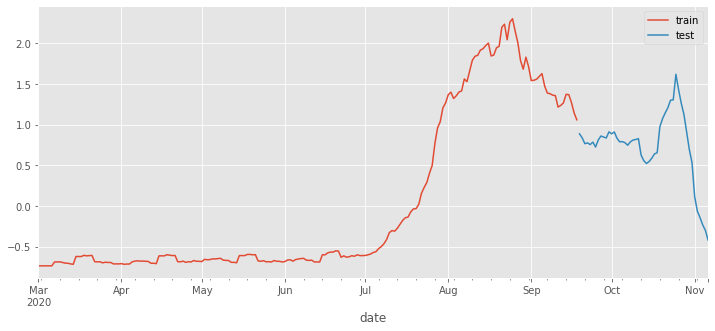

In [5]:
#@title
## select the data
final_data = df_join.loc[(df_join.index >= initial_date)
                         & (df_join.index <= final_date)]
# serie smoothing
if base_dset_params['smoothing']:
    final_data = final_data.rolling(base_dset_params['smooth']).mean().fillna(0)

# data split
final_data_train = final_data.loc[final_data.index <= train_final_date]
final_data_test = final_data.loc[final_data.index > train_final_date]
# train
bga_data_train, bga_scaler = dataset.series_transformer(
    final_data_train['BUCARAMANGA'].to_frame(),
    standarization=True,
    scaler=None)
# test
bga_data_test, bga_scaler = dataset.series_transformer(
    final_data_test['BUCARAMANGA'].to_frame(),
    standarization=True,
    scaler=bga_scaler)

ax = bga_data_train.rename(columns={'BUCARAMANGA':'train'}).plot(figsize=(12,5));
bga_data_test.rename(columns={'BUCARAMANGA':'test'}).plot(ax=ax);

## 1. Restructuración de datos para el enfoque directo

In [6]:
#@title 
ml_direct_train_dset_params = utils.copy_and_modify_dict(base_dset_params, {})
ml_direct_test_dset_params = utils.copy_and_modify_dict(base_dset_params,
                                                  {'shuffle_buffer': 0})

ml_direct_bga_dset_train = dataset.windowed_dataset(bga_data_train,
                                            ml_direct_train_dset_params,
                                            tf_dset=False,
                                            direct_dset=True)

ml_direct_bga_dset_test = dataset.windowed_dataset(bga_data_test,
                                           ml_direct_test_dset_params,
                                           tf_dset=False,
                                           direct_dset=True)

### A. SVM - Directo univariable (serie Bucaramanga)

### B. XGBoost - Directo univariable (serie Bucaramanga)

In [7]:
#@title
# hyper optimization
xgb_dir_params, xgb_dir_trials = optimize_direct_xgb(
    ml_direct_bga_dset_train['x'], ml_direct_bga_dset_train['y'], max_evals=50)

# Use the best params to train the best Direct XGBoost
xgb_dir_results = []
for idx, xgb_dir_param in enumerate(xgb_dir_params):
    xgb_dir_results.append(train_xgb(xgb_dir_param, ml_direct_bga_dset_train['x'][idx], 
                                     ml_direct_bga_dset_train['y'][idx]))
    
# Compute the Root Mean Square Error
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    cv_score = min([
        f["loss"] for f in xgb_dir_trials[idx].results if f["status"] == STATUS_OK
    ])
    #test_score = mape(ml_direct_bga_dset_test['y'][idx], xgb_preds_dir)
    test_score = metrics.mean_absolute_error(ml_direct_bga_dset_test['y'][idx], xgb_preds_dir)

    print(
        f"Direct Model {idx + 1}: Mean absolute error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
    )    

Optimizing XGBoosts models using a direct approach...
Finding best params for XGBoost model 0...
100%|██████████| 50/50 [00:52<00:00,  1.05s/it, best loss: 0.017516237807056325]

    Best parameters:
        learning_rate: 0.09747300047059837 
        n_estimators: 810.0
        max_depth: 3.0
        sub_sample: 0.8828318020784361
        gamma: 79.0
    
Finding best params for XGBoost model 1...
100%|██████████| 50/50 [00:44<00:00,  1.12it/s, best loss: 0.022030201214713392]

    Best parameters:
        learning_rate: 0.13210141401748002 
        n_estimators: 840.0
        max_depth: 5.0
        sub_sample: 0.8726227234421476
        gamma: 83.0
    
Finding best params for XGBoost model 2...
100%|██████████| 50/50 [00:45<00:00,  1.10it/s, best loss: 0.02656018850661406]

    Best parameters:
        learning_rate: 0.11130165351184182 
        n_estimators: 440.0
        max_depth: 2.0
        sub_sample: 0.8407422909665873
        gamma: 61.0
    
Finding best params for XGBoost 

### Guardar el modelo y verificar su reproducibilidad

In [8]:
#@title
# save the models
path = os.path.join('Forecasting_COVID_BGA/trained_models/xgb_direct/', name_folder, '')  
os.makedirs(path, exist_ok=True)

scalerfile = path+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_model_dir.save_model(path+'/xgb_direct_{}_model'.format(idx))
# Load and tests if all models give the same results
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    # Load the trained and saved models.
    xgb_dir_test = xgb.XGBRegressor()
    xgb_dir_test.load_model(path+'/xgb_direct_{}'.format(idx))

    # Compare predictions
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    xgb_preds_test = xgb_dir_test.predict(ml_direct_bga_dset_test['x'][idx])
    print('Predictions are equal:',
          np.array_equal(xgb_preds_dir, xgb_preds_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/xgb_direct/2020-09-18_21_14_True_True_False/scaler.pkl'>
  import sys


Predictions are equal: False
Predictions are equal: False
Predictions are equal: True
Predictions are equal: False
Predictions are equal: False
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True


#### Cargar el modelo y gráficar las predicciones

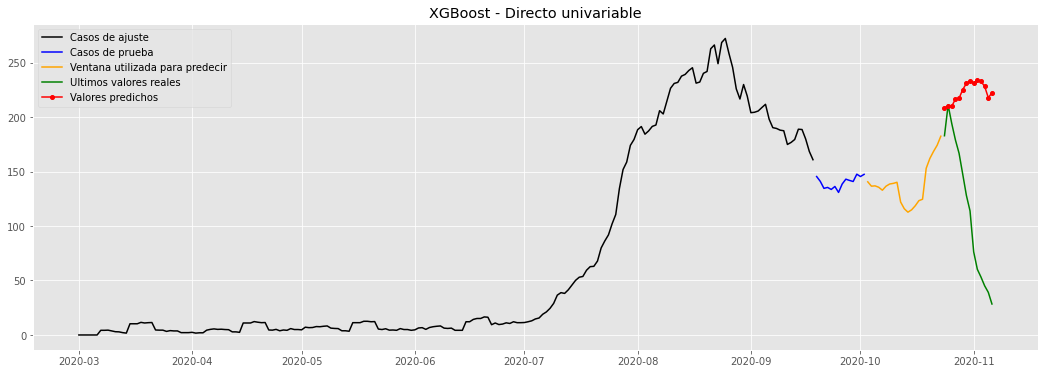

In [9]:
#@title
xgb_direct_models = load_direct_model(path)
utils.plot_serie_with_next_window_prediction(xgb_direct_models,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=False,
                                       title='XGBoost - Directo univariable')

## 2. Restructuración de datos para el enfoque recursivo

In [10]:
#@title 
ml_rec_train_dset_params = utils.copy_and_modify_dict(base_dset_params,
                                                {'future_window': 1})
ml_rec_test_dset_params = utils.copy_and_modify_dict(base_dset_params, {
    'shuffle_buffer': 0,
    'future_window': 1
})

ml_rec_bga_dset_train = dataset.windowed_dataset(bga_data_train,
                                         ml_rec_train_dset_params,
                                         tf_dset=False,
                                         direct_dset=False)

ml_rec_bga_dset_test = dataset.windowed_dataset(bga_data_test,
                                        ml_rec_test_dset_params,
                                        tf_dset=False,
                                        direct_dset=False)

### C. SVR - Recursivo univariable (serie Bucaramanga)

In [11]:
#@title
svr_rec_dir = os.path.join('Forecasting_COVID_BGA/trained_models/svr_recursive/', name_folder, '') 
#if os.path.exists(svr_rec_dir): shutil.rmtree(svr_rec_dir)
os.makedirs(svr_rec_dir, exist_ok=True)
scoring = metrics.make_scorer(metrics.mean_squared_error)

def build_model(hp):
    model = SVR(kernel=hp.Choice(
        'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
                degree=hp.Int('degree', 1, 10, step=1),
                gamma=hp.Choice('gamma', ['scale', 'auto']),
                coef0=hp.Float('coef0', 1e-3, 1, sampling='log'),
                C=hp.Float('C', 1e-3, 1, sampling='log'),
                epsilon=hp.Float('epsilon', 1e-3, 1e-1, sampling='log'))
    return model
# optimization
tuner = kt.tuners.Sklearn(oracle=kt.oracles.BayesianOptimization(
    objective=kt.Objective('score', 'min'), max_trials=50),
                          hypermodel=build_model, directory=svr_rec_dir, scoring=scoring,
                          project_name='svr_tuner'
                          )

tuner.search(ml_rec_bga_dset_train['x'], ml_rec_bga_dset_train['y'])
## get the best model
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])
# evaluate
#test_score = mape(ml_rec_bga_dset_test['y'], svr_preds_rec)
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], svr_preds_rec)
print(
    f"Mean absolute error test: {test_score:.4f}"
)

INFO:tensorflow:Oracle triggered exit
Mean absolute error test: 0.0905


### Guardar el modelo y verificar su reproducibilidad

Mean absolute error test:  0.09048072468336883
Predictions are equal: True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/svr_recursive/2020-09-18_21_14_True_True_False/scaler.pkl'>
  app.launch_new_instance()


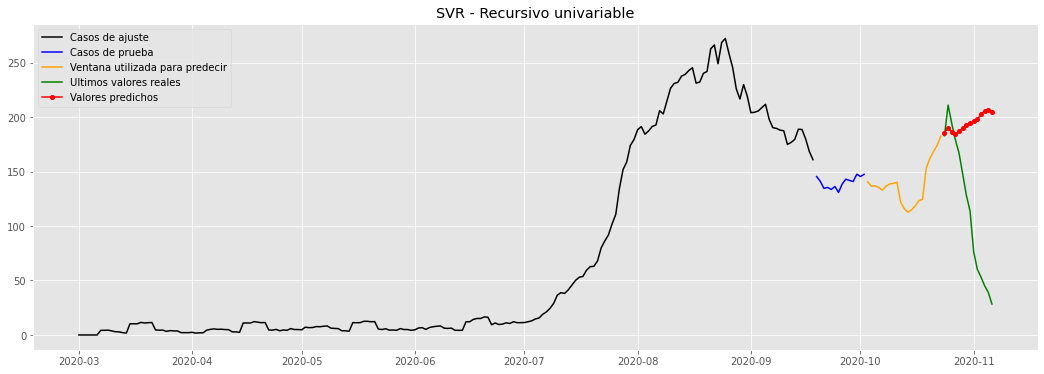

In [13]:
#@title 
#save the model
with open(svr_rec_dir+'svr_recursive_model.pkl', 'wb') as pickle_file:
    pkl.dump(best_model, pickle_file, protocol=pkl.HIGHEST_PROTOCOL)
#Load to test if it gives the same predictions    
with open(svr_rec_dir+'svr_recursive_model.pkl', 'rb') as pickle_file:
    svr_rec_test = pkl.load(pickle_file)
# test
svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])
svr_preds_test = svr_rec_test.predict(ml_rec_bga_dset_test['x'])
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], svr_preds_test)
print('Mean absolute error test: ', test_score)
print('Predictions are equal:',np.array_equal(svr_preds_rec, svr_preds_test))

scalerfile = svr_rec_dir+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

# plots
utils.plot_serie_with_next_window_prediction(svr_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='SVR - Recursivo univariable')

### D. XGBoost - Recursivo univariable (serie Bucaramanga)

In [14]:
#@title
xgb_rec_params, xgb_rec_trials = optimize_xgb(ml_rec_bga_dset_train['x'],
                                              ml_rec_bga_dset_train['y'],
                                              max_evals=50)

xgb_rec_res = train_xgb(xgb_rec_params, ml_rec_bga_dset_train['x'],
                        ml_rec_bga_dset_train['y'])

# Compute Mean Square Error   
xgb_model_rec = xgb_rec_res["model"]
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
cv_score = min(
    [f["loss"] for f in xgb_rec_trials.results if f["status"] == STATUS_OK])
#test_score = mape(ml_rec_bga_dset_test['y'], xgb_preds_rec)
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], xgb_preds_rec)
print(
    f"mean absolute error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
)

100%|██████████| 50/50 [00:35<00:00,  1.40it/s, best loss: 0.023863638745085677]

    Best parameters:
        learning_rate: 0.23229147719422824 
        n_estimators: 490.0
        max_depth: 3.0
        sub_sample: 0.9499742728681828
        gamma: 44.0
    
mean absolute error cross-validation/test: 0.0239 / 0.5577


### Guardar el modelo y verificar su reproducibilidad

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/xgb_recursive/2020-09-18_21_14_True_True_False/scaler.pkl'>
  """


Predictions are equal:  False


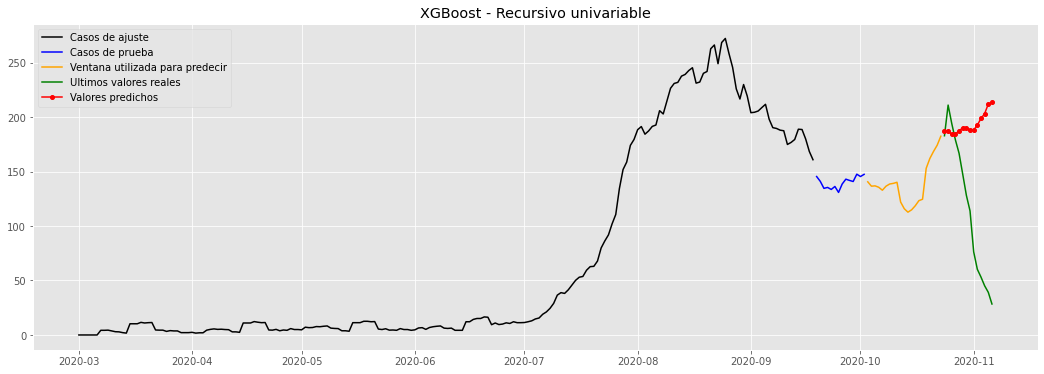

In [15]:
#@title
xgb_rec_path = os.path.join('Forecasting_COVID_BGA/trained_models/xgb_recursive/', name_folder, '') 
os.makedirs(xgb_rec_path, exist_ok=True)
scalerfile = xgb_rec_path+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)
xgb_model_rec.save_model(xgb_rec_path+'xgb_recursive_model')
#Load to test if it gives the same predictions
xgb_rec_test = xgb.XGBRegressor()
xgb_rec_test.load_model(xgb_rec_path+'xgb_recursive_model')
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
xgb_preds_test = xgb_rec_test.predict(ml_rec_bga_dset_test['x'])
print('Predictions are equal: ',np.array_equal(xgb_preds_rec, xgb_preds_test))
#plot
utils.plot_serie_with_next_window_prediction(xgb_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='XGBoost - Recursivo univariable')

## Modelos de aprendizaje profundo (DL)

## 3. Restructuración de datos para el enfoque directo univariable

In [24]:
#@title
dl_bga_dset_train = dataset.windowed_dataset(bga_data_train.values.reshape(-1,1).astype(np.float32),
                                            base_dset_params,
                                            tf_dset=True,
                                            direct_dset=None)

dl_bga_dset_test = dataset.windowed_dataset(bga_data_test.values.reshape(-1,1).astype(np.float32),
                                           base_dset_params,
                                           tf_dset=True,
                                           direct_dset=None)

### E. Modelo RNN - Directo univariable (Bucaramanga)

In [28]:
#@title
def build_standard_model(hp):
    # Extract values from dict.
    batch_size = base_dset_params['batch_size']
    window_size = base_dset_params['past_window']
    future_steps = base_dset_params['future_window']
    shuffle_buffer = base_dset_params['shuffle_buffer']
    feature_dim = base_dset_params['feature_dim']
    stateful = base_dset_params['stateful']

    # clean gpu and previous models
    tf.keras.backend.clear_session()
    gc.collect()
    # build the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size,feature_dim), batch_size=batch_size))
    # Shape [batch, time, series] => [batch, lstm_units]
    for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):
        model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i), [16, 32, 64, 128]), 
                                      return_sequences=True, stateful=stateful))
    model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i+1), [16, 32, 64, 128]), 
                                   return_sequences=False, stateful=stateful))
    # Shape [batch, lstm_units] => [batch, featuresDenseDim]
    model.add(tf.keras.layers.Dense(hp.Choice('units_' + str(i+2), [16, 32, 64, 128])))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(tf.keras.layers.Dense(future_steps))
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

# create folder
rnn_direct_dir = os.path.join('Forecasting_COVID_BGA/trained_models/rnn_direct_univariate/', name_folder, '') 
os.makedirs(rnn_direct_dir, exist_ok=True)

base_dset_params['feature_dim'] = 1
# build the tuner object for hyper opt
tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    directory=rnn_direct_dir,
    project_name='rnn_tuner'
)

# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dl_bga_dset_train,
             validation_data=dl_bga_dset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(vars(best_hyperparameters))
print(best_model.evaluate(dl_bga_dset_test))

Epoch 1/2
168/168 [==============================] - 4s 26ms/step - loss: 1.1010 - mean_absolute_error: 0.8985 - val_loss: 1.1020 - val_mean_absolute_error: 0.9647
Epoch 2/2
168/168 [==============================] - 3s 17ms/step - loss: 1.1024 - mean_absolute_error: 0.8978 - val_loss: 1.0991 - val_mean_absolute_error: 0.9634


Epoch 1/2
168/168 [==============================] - 3s 15ms/step - loss: 0.5742 - mean_absolute_error: 0.5889 - val_loss: 0.2589 - val_mean_absolute_error: 0.4237
Epoch 2/2
168/168 [==============================] - 2s 11ms/step - loss: 0.0943 - mean_absolute_error: 0.2170 - val_loss: 0.2514 - val_mean_absolute_error: 0.3934


Epoch 1/2
168/168 [==============================] - 6s 36ms/step - loss: 1.0763 - mean_absolute_error: 0.8884 - val_loss: 1.0788 - val_mean_absolute_error: 0.9541
Epoch 2/2
168/168 [==============================] - 4s 26ms/step - loss: 1.0746 - mean_absolute_error: 0.8873 - val_loss: 1.0777 - val_mean_absolute_error: 0.9536


Epoch 1/2
168/168 [==============================] - 4s 22ms/step - loss: 1.0421 - mean_absolute_error: 0.8735 - val_loss: 1.0465 - val_mean_absolute_error: 0.9354
Epoch 2/2
168/168 [==============================] - 3s 16ms/step - loss: 1.0403 - mean_absolute_error: 0.8730 - val_loss: 1.0465 - val_mean_absolute_error: 0.9354


Epoch 1/2
168/168 [==============================] - 3s 20ms/step - loss: 1.0924 - mean_absolute_error: 0.8948 - val_loss: 1.0918 - val_mean_absolute_error: 0.9599
Epoch 2/2
168/168 [==============================] - 2s 15ms/step - loss: 1.0915 - mean_absolute_error: 0.8944 - val_loss: 1.0910 - val_mean_absolute_error: 0.9596


Epoch 1/2
168/168 [==============================] - 4s 23ms/step - loss: 1.0923 - mean_absolute_error: 0.8930 - val_loss: 1.0898 - val_mean_absolute_error: 0.9590
Epoch 2/2
168/168 [==============================] - 3s 17ms/step - loss: 1.0997 - mean_absolute_error: 0.8932 - val_loss: 1.0897 - val_mean_absolute_error: 0.9590


Epoch 1/2
168/168 [==============================] - 3s 15ms/step - loss: 1.1285 - mean_absolute_error: 0.9061 - val_loss: 1.1128 - val_mean_absolute_error: 0.9648
Epoch 2/2
168/168 [==============================] - 2s 12ms/step - loss: 1.1315 - mean_absolute_error: 0.9072 - val_loss: 1.1127 - val_mean_absolute_error: 0.9648


Epoch 1/2
168/168 [==============================] - 3s 17ms/step - loss: 1.0448 - mean_absolute_error: 0.8720 - val_loss: 1.0426 - val_mean_absolute_error: 0.9321
Epoch 2/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0435 - mean_absolute_error: 0.8711 - val_loss: 1.0363 - val_mean_absolute_error: 0.9293


Epoch 1/2
168/168 [==============================] - 4s 21ms/step - loss: 1.0442 - mean_absolute_error: 0.8731 - val_loss: 1.0477 - val_mean_absolute_error: 0.9386
Epoch 2/2
168/168 [==============================] - 3s 17ms/step - loss: 1.0350 - mean_absolute_error: 0.8694 - val_loss: 1.0377 - val_mean_absolute_error: 0.9340


Epoch 1/2
168/168 [==============================] - 4s 22ms/step - loss: 0.9356 - mean_absolute_error: 0.7834 - val_loss: 0.5963 - val_mean_absolute_error: 0.6448
Epoch 2/2
168/168 [==============================] - 3s 16ms/step - loss: 0.4479 - mean_absolute_error: 0.5224 - val_loss: 0.2478 - val_mean_absolute_error: 0.4050


Epoch 1/2
168/168 [==============================] - 5s 29ms/step - loss: 1.0667 - mean_absolute_error: 0.8825 - val_loss: 1.0604 - val_mean_absolute_error: 0.9430
Epoch 2/2
168/168 [==============================] - 3s 21ms/step - loss: 1.0583 - mean_absolute_error: 0.8793 - val_loss: 1.0502 - val_mean_absolute_error: 0.9383


Epoch 1/2
168/168 [==============================] - 3s 17ms/step - loss: 1.0238 - mean_absolute_error: 0.8609 - val_loss: 1.0066 - val_mean_absolute_error: 0.9201
Epoch 2/2
168/168 [==============================] - 2s 12ms/step - loss: 0.9691 - mean_absolute_error: 0.8390 - val_loss: 0.9511 - val_mean_absolute_error: 0.8949


Epoch 1/2
168/168 [==============================] - 5s 30ms/step - loss: 1.0863 - mean_absolute_error: 0.8925 - val_loss: 1.0879 - val_mean_absolute_error: 0.9582
Epoch 2/2
168/168 [==============================] - 4s 22ms/step - loss: 1.0840 - mean_absolute_error: 0.8914 - val_loss: 1.0879 - val_mean_absolute_error: 0.9582


Epoch 1/2
168/168 [==============================] - 4s 21ms/step - loss: 1.1063 - mean_absolute_error: 0.8898 - val_loss: 1.0255 - val_mean_absolute_error: 0.9265
Epoch 2/2
168/168 [==============================] - 3s 15ms/step - loss: 1.0233 - mean_absolute_error: 0.8626 - val_loss: 0.9473 - val_mean_absolute_error: 0.8870


Epoch 1/2
168/168 [==============================] - 4s 25ms/step - loss: 1.0948 - mean_absolute_error: 0.8964 - val_loss: 1.0913 - val_mean_absolute_error: 0.9587
Epoch 2/2
168/168 [==============================] - 3s 20ms/step - loss: 1.0951 - mean_absolute_error: 0.8968 - val_loss: 1.0902 - val_mean_absolute_error: 0.9582


Epoch 1/2
168/168 [==============================] - 3s 15ms/step - loss: 0.9994 - mean_absolute_error: 0.8407 - val_loss: 0.9681 - val_mean_absolute_error: 0.8929
Epoch 2/2
168/168 [==============================] - 2s 10ms/step - loss: 0.9432 - mean_absolute_error: 0.8186 - val_loss: 0.9078 - val_mean_absolute_error: 0.8600


Epoch 1/2
168/168 [==============================] - 4s 24ms/step - loss: 1.0940 - mean_absolute_error: 0.8954 - val_loss: 1.0865 - val_mean_absolute_error: 0.9556
Epoch 2/2
168/168 [==============================] - 3s 18ms/step - loss: 1.0871 - mean_absolute_error: 0.8940 - val_loss: 1.0859 - val_mean_absolute_error: 0.9554


Epoch 1/2
168/168 [==============================] - 4s 25ms/step - loss: 1.0681 - mean_absolute_error: 0.8854 - val_loss: 1.0704 - val_mean_absolute_error: 0.9474
Epoch 2/2
168/168 [==============================] - 3s 19ms/step - loss: 1.0668 - mean_absolute_error: 0.8848 - val_loss: 1.0703 - val_mean_absolute_error: 0.9474


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 1.1647 - mean_absolute_error: 0.9197 - val_loss: 1.1350 - val_mean_absolute_error: 0.9746
Epoch 2/2
168/168 [==============================] - 2s 11ms/step - loss: 1.1515 - mean_absolute_error: 0.9146 - val_loss: 1.1209 - val_mean_absolute_error: 0.9681


Epoch 1/2
168/168 [==============================] - 6s 34ms/step - loss: 1.0395 - mean_absolute_error: 0.8652 - val_loss: 1.0258 - val_mean_absolute_error: 0.9285
Epoch 2/2
168/168 [==============================] - 4s 25ms/step - loss: 1.0156 - mean_absolute_error: 0.8580 - val_loss: 0.9904 - val_mean_absolute_error: 0.9112


Epoch 1/2
168/168 [==============================] - 3s 16ms/step - loss: 1.0162 - mean_absolute_error: 0.8528 - val_loss: 0.9827 - val_mean_absolute_error: 0.9065
Epoch 2/2
168/168 [==============================] - 2s 13ms/step - loss: 0.9420 - mean_absolute_error: 0.8205 - val_loss: 0.9023 - val_mean_absolute_error: 0.8676


Epoch 1/2
168/168 [==============================] - 4s 25ms/step - loss: 1.0558 - mean_absolute_error: 0.8806 - val_loss: 1.0630 - val_mean_absolute_error: 0.9444
Epoch 2/2
168/168 [==============================] - 3s 19ms/step - loss: 1.0563 - mean_absolute_error: 0.8805 - val_loss: 1.0629 - val_mean_absolute_error: 0.9443


Epoch 1/2
168/168 [==============================] - 5s 32ms/step - loss: 0.6584 - mean_absolute_error: 0.6463 - val_loss: 0.2478 - val_mean_absolute_error: 0.4131
Epoch 2/2
168/168 [==============================] - 2s 12ms/step - loss: 0.1077 - mean_absolute_error: 0.2358 - val_loss: 0.2873 - val_mean_absolute_error: 0.3976


Epoch 1/2
168/168 [==============================] - 4s 24ms/step - loss: 0.6187 - mean_absolute_error: 0.6146 - val_loss: 0.2514 - val_mean_absolute_error: 0.4148
Epoch 2/2
168/168 [==============================] - 3s 17ms/step - loss: 0.1849 - mean_absolute_error: 0.3166 - val_loss: 0.2373 - val_mean_absolute_error: 0.3929


Epoch 1/2
168/168 [==============================] - 4s 22ms/step - loss: 0.8318 - mean_absolute_error: 0.7369 - val_loss: 0.2840 - val_mean_absolute_error: 0.4484
Epoch 2/2
168/168 [==============================] - 3s 16ms/step - loss: 0.1538 - mean_absolute_error: 0.2935 - val_loss: 0.3754 - val_mean_absolute_error: 0.4587


Epoch 1/2
168/168 [==============================] - 5s 30ms/step - loss: 1.0466 - mean_absolute_error: 0.8665 - val_loss: 1.0305 - val_mean_absolute_error: 0.9316
Epoch 2/2
168/168 [==============================] - 4s 21ms/step - loss: 1.0182 - mean_absolute_error: 0.8577 - val_loss: 0.9910 - val_mean_absolute_error: 0.9129


Epoch 1/2
168/168 [==============================] - 4s 22ms/step - loss: 1.0651 - mean_absolute_error: 0.8820 - val_loss: 1.0679 - val_mean_absolute_error: 0.9456
Epoch 2/2
168/168 [==============================] - 3s 18ms/step - loss: 1.0624 - mean_absolute_error: 0.8810 - val_loss: 1.0644 - val_mean_absolute_error: 0.9439


Epoch 1/2
168/168 [==============================] - 7s 40ms/step - loss: 1.0775 - mean_absolute_error: 0.8894 - val_loss: 1.0811 - val_mean_absolute_error: 0.9538
Epoch 2/2
168/168 [==============================] - 4s 26ms/step - loss: 1.0812 - mean_absolute_error: 0.8904 - val_loss: 1.0802 - val_mean_absolute_error: 0.9533


Epoch 1/2
168/168 [==============================] - 3s 17ms/step - loss: 1.0769 - mean_absolute_error: 0.8831 - val_loss: 1.0007 - val_mean_absolute_error: 0.9141
Epoch 2/2
168/168 [==============================] - 2s 14ms/step - loss: 0.9280 - mean_absolute_error: 0.8177 - val_loss: 0.8928 - val_mean_absolute_error: 0.8562


Epoch 1/2
168/168 [==============================] - 4s 22ms/step - loss: 0.6475 - mean_absolute_error: 0.6302 - val_loss: 0.2466 - val_mean_absolute_error: 0.3939
Epoch 2/2
168/168 [==============================] - 3s 17ms/step - loss: 0.1436 - mean_absolute_error: 0.2794 - val_loss: 0.2959 - val_mean_absolute_error: 0.3990


Epoch 1/2
168/168 [==============================] - 3s 15ms/step - loss: 1.0740 - mean_absolute_error: 0.8830 - val_loss: 1.0640 - val_mean_absolute_error: 0.9461
Epoch 2/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0627 - mean_absolute_error: 0.8786 - val_loss: 1.0581 - val_mean_absolute_error: 0.9435


Epoch 1/2
168/168 [==============================] - 4s 21ms/step - loss: 1.0058 - mean_absolute_error: 0.8569 - val_loss: 1.0223 - val_mean_absolute_error: 0.9217
Epoch 2/2
168/168 [==============================] - 2s 15ms/step - loss: 1.0068 - mean_absolute_error: 0.8578 - val_loss: 1.0222 - val_mean_absolute_error: 0.9217


Epoch 1/2
168/168 [==============================] - 4s 23ms/step - loss: 0.7545 - mean_absolute_error: 0.6938 - val_loss: 0.3212 - val_mean_absolute_error: 0.4722
Epoch 2/2
168/168 [==============================] - 3s 18ms/step - loss: 0.2826 - mean_absolute_error: 0.4110 - val_loss: 0.2349 - val_mean_absolute_error: 0.3973


Epoch 1/2
168/168 [==============================] - 4s 25ms/step - loss: 1.0003 - mean_absolute_error: 0.8463 - val_loss: 0.9644 - val_mean_absolute_error: 0.8991
Epoch 2/2
168/168 [==============================] - 3s 20ms/step - loss: 0.9071 - mean_absolute_error: 0.8067 - val_loss: 0.8637 - val_mean_absolute_error: 0.8465


Epoch 3/4
168/168 [==============================] - 4s 23ms/step - loss: 0.4969 - mean_absolute_error: 0.5355 - val_loss: 0.2440 - val_mean_absolute_error: 0.3904
Epoch 4/4
168/168 [==============================] - 3s 17ms/step - loss: 0.1646 - mean_absolute_error: 0.2979 - val_loss: 0.2381 - val_mean_absolute_error: 0.3884


Epoch 3/4
168/168 [==============================] - 3s 16ms/step - loss: 0.5943 - mean_absolute_error: 0.6053 - val_loss: 0.2543 - val_mean_absolute_error: 0.4202
Epoch 4/4
168/168 [==============================] - 2s 12ms/step - loss: 0.0920 - mean_absolute_error: 0.2112 - val_loss: 0.2431 - val_mean_absolute_error: 0.3971


Epoch 3/4
168/168 [==============================] - 4s 24ms/step - loss: 0.7795 - mean_absolute_error: 0.7028 - val_loss: 0.2747 - val_mean_absolute_error: 0.4297
Epoch 4/4
168/168 [==============================] - 3s 17ms/step - loss: 0.1663 - mean_absolute_error: 0.3090 - val_loss: 0.3010 - val_mean_absolute_error: 0.3975


Epoch 3/4
168/168 [==============================] - 4s 23ms/step - loss: 0.6666 - mean_absolute_error: 0.6469 - val_loss: 0.2880 - val_mean_absolute_error: 0.4474
Epoch 4/4
168/168 [==============================] - 3s 17ms/step - loss: 0.2964 - mean_absolute_error: 0.4056 - val_loss: 0.2208 - val_mean_absolute_error: 0.3971


Epoch 3/4
168/168 [==============================] - 3s 16ms/step - loss: 0.6497 - mean_absolute_error: 0.6405 - val_loss: 0.2784 - val_mean_absolute_error: 0.4359
Epoch 4/4
168/168 [==============================] - 2s 12ms/step - loss: 0.1115 - mean_absolute_error: 0.2431 - val_loss: 0.3114 - val_mean_absolute_error: 0.4030


Epoch 3/4
168/168 [==============================] - 4s 22ms/step - loss: 0.8699 - mean_absolute_error: 0.7493 - val_loss: 0.5358 - val_mean_absolute_error: 0.6178
Epoch 4/4
168/168 [==============================] - 3s 17ms/step - loss: 0.3918 - mean_absolute_error: 0.4943 - val_loss: 0.2838 - val_mean_absolute_error: 0.4203


Epoch 3/4
168/168 [==============================] - 4s 21ms/step - loss: 0.6176 - mean_absolute_error: 0.6203 - val_loss: 0.2518 - val_mean_absolute_error: 0.3953
Epoch 4/4
168/168 [==============================] - 3s 15ms/step - loss: 0.0955 - mean_absolute_error: 0.2244 - val_loss: 0.3677 - val_mean_absolute_error: 0.4463


Epoch 3/4
168/168 [==============================] - 4s 25ms/step - loss: 1.0171 - mean_absolute_error: 0.8545 - val_loss: 0.9822 - val_mean_absolute_error: 0.9070
Epoch 4/4
168/168 [==============================] - 3s 19ms/step - loss: 0.9365 - mean_absolute_error: 0.8230 - val_loss: 0.8880 - val_mean_absolute_error: 0.8592


Epoch 3/4
168/168 [==============================] - 3s 17ms/step - loss: 1.0078 - mean_absolute_error: 0.8507 - val_loss: 0.9726 - val_mean_absolute_error: 0.9034
Epoch 4/4
168/168 [==============================] - 2s 13ms/step - loss: 0.8875 - mean_absolute_error: 0.7977 - val_loss: 0.8700 - val_mean_absolute_error: 0.8509


Epoch 3/4
168/168 [==============================] - 3s 15ms/step - loss: 0.9110 - mean_absolute_error: 0.7926 - val_loss: 0.8447 - val_mean_absolute_error: 0.8351
Epoch 4/4
168/168 [==============================] - 2s 11ms/step - loss: 0.7863 - mean_absolute_error: 0.7280 - val_loss: 0.7261 - val_mean_absolute_error: 0.7662


Epoch 3/4
168/168 [==============================] - 2s 15ms/step - loss: 1.0839 - mean_absolute_error: 0.8861 - val_loss: 1.0606 - val_mean_absolute_error: 0.9465
Epoch 4/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0375 - mean_absolute_error: 0.8688 - val_loss: 1.0162 - val_mean_absolute_error: 0.9261


Epoch 3/4
168/168 [==============================] - 4s 21ms/step - loss: 1.0392 - mean_absolute_error: 0.8601 - val_loss: 1.0012 - val_mean_absolute_error: 0.9155
Epoch 4/4
168/168 [==============================] - 3s 15ms/step - loss: 0.9719 - mean_absolute_error: 0.8321 - val_loss: 0.9293 - val_mean_absolute_error: 0.8796


Epoch 5/10
168/168 [==============================] - 4s 24ms/step - loss: 0.4940 - mean_absolute_error: 0.5390 - val_loss: 0.2322 - val_mean_absolute_error: 0.3887
Epoch 6/10
168/168 [==============================] - 3s 18ms/step - loss: 0.1400 - mean_absolute_error: 0.2735 - val_loss: 0.2263 - val_mean_absolute_error: 0.3850
Epoch 7/10
168/168 [==============================] - 3s 18ms/step - loss: 0.1272 - mean_absolute_error: 0.2607 - val_loss: 0.2335 - val_mean_absolute_error: 0.3825
Epoch 8/10
168/168 [==============================] - 3s 19ms/step - loss: 0.1243 - mean_absolute_error: 0.2555 - val_loss: 0.2401 - val_mean_absolute_error: 0.3834
Epoch 9/10
168/168 [==============================] - 3s 18ms/step - loss: 0.1151 - mean_absolute_error: 0.2407 - val_loss: 0.2608 - val_mean_absolute_error: 0.3850
Epoch 10/10
168/168 [==============================] - 3s 19ms/step - loss: 0.1078 - mean_absolute_error: 0.2351 - val_loss: 0.2558 - val_mean_absolute_error: 0.3828


Epoch 5/10
168/168 [==============================] - 4s 22ms/step - loss: 0.7931 - mean_absolute_error: 0.7141 - val_loss: 0.2631 - val_mean_absolute_error: 0.4314
Epoch 6/10
168/168 [==============================] - 3s 16ms/step - loss: 0.1422 - mean_absolute_error: 0.2791 - val_loss: 0.3716 - val_mean_absolute_error: 0.4552
Epoch 7/10
168/168 [==============================] - 3s 15ms/step - loss: 0.0817 - mean_absolute_error: 0.2064 - val_loss: 0.3714 - val_mean_absolute_error: 0.4503
Epoch 8/10
168/168 [==============================] - 3s 15ms/step - loss: 0.0776 - mean_absolute_error: 0.1986 - val_loss: 0.4461 - val_mean_absolute_error: 0.5099


Epoch 5/10
168/168 [==============================] - 3s 17ms/step - loss: 0.4108 - mean_absolute_error: 0.4841 - val_loss: 0.2450 - val_mean_absolute_error: 0.4013
Epoch 6/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0825 - mean_absolute_error: 0.1974 - val_loss: 0.2498 - val_mean_absolute_error: 0.3921
Epoch 7/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0840 - mean_absolute_error: 0.2008 - val_loss: 0.2599 - val_mean_absolute_error: 0.3899
Epoch 8/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0783 - mean_absolute_error: 0.1951 - val_loss: 0.2601 - val_mean_absolute_error: 0.3886
Epoch 9/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0726 - mean_absolute_error: 0.1898 - val_loss: 0.2622 - val_mean_absolute_error: 0.3881
Epoch 10/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0709 - mean_absolute_error: 0.1863 - val_loss: 0.2685 - val_mean_absolute_error: 0.3891


Epoch 5/10
168/168 [==============================] - 4s 23ms/step - loss: 0.4705 - mean_absolute_error: 0.5215 - val_loss: 0.2436 - val_mean_absolute_error: 0.4012
Epoch 6/10
168/168 [==============================] - 3s 17ms/step - loss: 0.2187 - mean_absolute_error: 0.3456 - val_loss: 0.2400 - val_mean_absolute_error: 0.4070
Epoch 7/10
168/168 [==============================] - 3s 17ms/step - loss: 0.1990 - mean_absolute_error: 0.3292 - val_loss: 0.2420 - val_mean_absolute_error: 0.3885
Epoch 8/10
168/168 [==============================] - 3s 18ms/step - loss: 0.1742 - mean_absolute_error: 0.3015 - val_loss: 0.2506 - val_mean_absolute_error: 0.3843
Epoch 9/10
168/168 [==============================] - 3s 19ms/step - loss: 0.1636 - mean_absolute_error: 0.2939 - val_loss: 0.2500 - val_mean_absolute_error: 0.3829
Epoch 10/10
168/168 [==============================] - 3s 19ms/step - loss: 0.1482 - mean_absolute_error: 0.2758 - val_loss: 0.3015 - val_mean_absolute_error: 0.3973


Epoch 11/30
168/168 [==============================] - 4s 24ms/step - loss: 0.5765 - mean_absolute_error: 0.5946 - val_loss: 0.2336 - val_mean_absolute_error: 0.4051
Epoch 12/30
168/168 [==============================] - 3s 17ms/step - loss: 0.1556 - mean_absolute_error: 0.2883 - val_loss: 0.2560 - val_mean_absolute_error: 0.3883
Epoch 13/30
168/168 [==============================] - 3s 17ms/step - loss: 0.1280 - mean_absolute_error: 0.2617 - val_loss: 0.2949 - val_mean_absolute_error: 0.3980
Epoch 14/30
168/168 [==============================] - 3s 18ms/step - loss: 0.1249 - mean_absolute_error: 0.2544 - val_loss: 0.3135 - val_mean_absolute_error: 0.4086
Epoch 15/30
168/168 [==============================] - 3s 18ms/step - loss: 0.1062 - mean_absolute_error: 0.2350 - val_loss: 0.3306 - val_mean_absolute_error: 0.4218


Epoch 11/30
168/168 [==============================] - 4s 22ms/step - loss: 0.5270 - mean_absolute_error: 0.5606 - val_loss: 0.2516 - val_mean_absolute_error: 0.3992
Epoch 12/30
168/168 [==============================] - 3s 19ms/step - loss: 0.2532 - mean_absolute_error: 0.3698 - val_loss: 0.2260 - val_mean_absolute_error: 0.3858
Epoch 13/30
168/168 [==============================] - 3s 19ms/step - loss: 0.1845 - mean_absolute_error: 0.3183 - val_loss: 0.2521 - val_mean_absolute_error: 0.3805
Epoch 14/30
168/168 [==============================] - 3s 17ms/step - loss: 0.1745 - mean_absolute_error: 0.3035 - val_loss: 0.2267 - val_mean_absolute_error: 0.3923
Epoch 15/30
168/168 [==============================] - 3s 17ms/step - loss: 0.1749 - mean_absolute_error: 0.2972 - val_loss: 0.2287 - val_mean_absolute_error: 0.3777
Epoch 16/30
168/168 [==============================] - 3s 17ms/step - loss: 0.1469 - mean_absolute_error: 0.2775 - val_loss: 0.2443 - val_mean_absolute_error: 0.3771
Epoc

Epoch 1/4
168/168 [==============================] - 3s 16ms/step - loss: 1.0680 - mean_absolute_error: 0.8769 - val_loss: 1.0242 - val_mean_absolute_error: 0.9284
Epoch 2/4
168/168 [==============================] - 2s 12ms/step - loss: 0.9934 - mean_absolute_error: 0.8473 - val_loss: 0.9542 - val_mean_absolute_error: 0.8930
Epoch 3/4
168/168 [==============================] - 2s 12ms/step - loss: 0.9194 - mean_absolute_error: 0.8147 - val_loss: 0.8803 - val_mean_absolute_error: 0.8532
Epoch 4/4
168/168 [==============================] - 2s 12ms/step - loss: 0.8444 - mean_absolute_error: 0.7782 - val_loss: 0.8023 - val_mean_absolute_error: 0.8074


Epoch 1/4
168/168 [==============================] - 4s 23ms/step - loss: 0.5640 - mean_absolute_error: 0.5779 - val_loss: 0.2767 - val_mean_absolute_error: 0.4282
Epoch 2/4
168/168 [==============================] - 3s 17ms/step - loss: 0.2479 - mean_absolute_error: 0.3594 - val_loss: 0.2438 - val_mean_absolute_error: 0.4138
Epoch 3/4
168/168 [==============================] - 3s 19ms/step - loss: 0.2129 - mean_absolute_error: 0.3394 - val_loss: 0.2346 - val_mean_absolute_error: 0.4047
Epoch 4/4
168/168 [==============================] - 3s 19ms/step - loss: 0.1737 - mean_absolute_error: 0.3066 - val_loss: 0.2328 - val_mean_absolute_error: 0.3933


Epoch 1/4
168/168 [==============================] - 5s 31ms/step - loss: 1.0453 - mean_absolute_error: 0.8681 - val_loss: 1.0294 - val_mean_absolute_error: 0.9315
Epoch 2/4
168/168 [==============================] - 4s 22ms/step - loss: 1.0281 - mean_absolute_error: 0.8632 - val_loss: 1.0024 - val_mean_absolute_error: 0.9197
Epoch 3/4
168/168 [==============================] - 4s 21ms/step - loss: 0.9957 - mean_absolute_error: 0.8511 - val_loss: 0.9589 - val_mean_absolute_error: 0.8992
Epoch 4/4
168/168 [==============================] - 4s 21ms/step - loss: 0.9598 - mean_absolute_error: 0.8366 - val_loss: 0.9010 - val_mean_absolute_error: 0.8710


Epoch 1/4
168/168 [==============================] - 3s 15ms/step - loss: 1.0909 - mean_absolute_error: 0.8930 - val_loss: 1.0836 - val_mean_absolute_error: 0.9527
Epoch 2/4
168/168 [==============================] - 2s 12ms/step - loss: 1.0915 - mean_absolute_error: 0.8930 - val_loss: 1.0835 - val_mean_absolute_error: 0.9527
Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0931 - mean_absolute_error: 0.8938 - val_loss: 1.0834 - val_mean_absolute_error: 0.9526
Epoch 4/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0869 - mean_absolute_error: 0.8918 - val_loss: 1.0833 - val_mean_absolute_error: 0.9526


Epoch 1/4
168/168 [==============================] - 5s 30ms/step - loss: 1.0880 - mean_absolute_error: 0.8936 - val_loss: 1.0860 - val_mean_absolute_error: 0.9565
Epoch 2/4
168/168 [==============================] - 4s 23ms/step - loss: 1.0855 - mean_absolute_error: 0.8928 - val_loss: 1.0817 - val_mean_absolute_error: 0.9545
Epoch 3/4
168/168 [==============================] - 4s 22ms/step - loss: 1.0810 - mean_absolute_error: 0.8910 - val_loss: 1.0769 - val_mean_absolute_error: 0.9523
Epoch 4/4
168/168 [==============================] - 4s 22ms/step - loss: 1.0765 - mean_absolute_error: 0.8893 - val_loss: 1.0724 - val_mean_absolute_error: 0.9502


Epoch 1/4
168/168 [==============================] - 3s 16ms/step - loss: 0.6063 - mean_absolute_error: 0.6190 - val_loss: 0.2720 - val_mean_absolute_error: 0.4276
Epoch 2/4
168/168 [==============================] - 2s 11ms/step - loss: 0.2503 - mean_absolute_error: 0.3711 - val_loss: 0.2447 - val_mean_absolute_error: 0.3949
Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 0.2006 - mean_absolute_error: 0.3240 - val_loss: 0.2425 - val_mean_absolute_error: 0.4051
Epoch 4/4
168/168 [==============================] - 2s 11ms/step - loss: 0.1806 - mean_absolute_error: 0.3013 - val_loss: 0.2819 - val_mean_absolute_error: 0.3946


Epoch 1/4
168/168 [==============================] - 5s 31ms/step - loss: 1.0728 - mean_absolute_error: 0.8882 - val_loss: 1.0753 - val_mean_absolute_error: 0.9499
Epoch 2/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0726 - mean_absolute_error: 0.8881 - val_loss: 1.0749 - val_mean_absolute_error: 0.9498
Epoch 3/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0724 - mean_absolute_error: 0.8881 - val_loss: 1.0746 - val_mean_absolute_error: 0.9496
Epoch 4/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0721 - mean_absolute_error: 0.8880 - val_loss: 1.0743 - val_mean_absolute_error: 0.9495


Epoch 1/4
168/168 [==============================] - 3s 16ms/step - loss: 1.0883 - mean_absolute_error: 0.8721 - val_loss: 1.0166 - val_mean_absolute_error: 0.9116
Epoch 2/4
168/168 [==============================] - 2s 11ms/step - loss: 0.9774 - mean_absolute_error: 0.8285 - val_loss: 0.9336 - val_mean_absolute_error: 0.8733
Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 0.8759 - mean_absolute_error: 0.7815 - val_loss: 0.8399 - val_mean_absolute_error: 0.8261
Epoch 4/4
168/168 [==============================] - 2s 11ms/step - loss: 0.7931 - mean_absolute_error: 0.7384 - val_loss: 0.7502 - val_mean_absolute_error: 0.7761


Epoch 1/4
168/168 [==============================] - 4s 26ms/step - loss: 1.0347 - mean_absolute_error: 0.8694 - val_loss: 1.0444 - val_mean_absolute_error: 0.9343
Epoch 2/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0351 - mean_absolute_error: 0.8697 - val_loss: 1.0443 - val_mean_absolute_error: 0.9343
Epoch 3/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0323 - mean_absolute_error: 0.8682 - val_loss: 1.0442 - val_mean_absolute_error: 0.9343
Epoch 4/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0380 - mean_absolute_error: 0.8707 - val_loss: 1.0442 - val_mean_absolute_error: 0.9342


Epoch 1/4
168/168 [==============================] - 4s 25ms/step - loss: 1.0607 - mean_absolute_error: 0.8773 - val_loss: 1.0590 - val_mean_absolute_error: 0.9434
Epoch 2/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0434 - mean_absolute_error: 0.8716 - val_loss: 1.0460 - val_mean_absolute_error: 0.9374
Epoch 3/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0388 - mean_absolute_error: 0.8667 - val_loss: 1.0367 - val_mean_absolute_error: 0.9332
Epoch 4/4
168/168 [==============================] - 3s 20ms/step - loss: 1.0178 - mean_absolute_error: 0.8586 - val_loss: 1.0254 - val_mean_absolute_error: 0.9280


Epoch 1/4
168/168 [==============================] - 3s 17ms/step - loss: 0.5098 - mean_absolute_error: 0.5489 - val_loss: 0.2602 - val_mean_absolute_error: 0.4292
Epoch 2/4
168/168 [==============================] - 2s 13ms/step - loss: 0.0993 - mean_absolute_error: 0.2217 - val_loss: 0.2469 - val_mean_absolute_error: 0.4131
Epoch 3/4
168/168 [==============================] - 2s 13ms/step - loss: 0.0956 - mean_absolute_error: 0.2159 - val_loss: 0.2493 - val_mean_absolute_error: 0.4168
Epoch 4/4
168/168 [==============================] - 2s 12ms/step - loss: 0.0929 - mean_absolute_error: 0.2142 - val_loss: 0.2456 - val_mean_absolute_error: 0.4100


Epoch 1/4
168/168 [==============================] - 5s 32ms/step - loss: 1.0900 - mean_absolute_error: 0.8949 - val_loss: 1.0901 - val_mean_absolute_error: 0.9604
Epoch 2/4
168/168 [==============================] - 4s 24ms/step - loss: 1.0902 - mean_absolute_error: 0.8950 - val_loss: 1.0894 - val_mean_absolute_error: 0.9601
Epoch 3/4
168/168 [==============================] - 4s 23ms/step - loss: 1.0885 - mean_absolute_error: 0.8944 - val_loss: 1.0888 - val_mean_absolute_error: 0.9599
Epoch 4/4
168/168 [==============================] - 4s 21ms/step - loss: 1.0887 - mean_absolute_error: 0.8945 - val_loss: 1.0882 - val_mean_absolute_error: 0.9596


Epoch 1/4
168/168 [==============================] - 8s 50ms/step - loss: 1.1067 - mean_absolute_error: 0.9019 - val_loss: 1.1090 - val_mean_absolute_error: 0.9695
Epoch 2/4
168/168 [==============================] - 4s 23ms/step - loss: 1.1073 - mean_absolute_error: 0.9016 - val_loss: 1.1083 - val_mean_absolute_error: 0.9691
Epoch 3/4
168/168 [==============================] - 4s 22ms/step - loss: 1.1096 - mean_absolute_error: 0.9024 - val_loss: 1.1075 - val_mean_absolute_error: 0.9688
Epoch 4/4
168/168 [==============================] - 4s 23ms/step - loss: 1.1047 - mean_absolute_error: 0.9008 - val_loss: 1.1068 - val_mean_absolute_error: 0.9685


Epoch 1/4
168/168 [==============================] - 3s 15ms/step - loss: 1.0212 - mean_absolute_error: 0.8571 - val_loss: 1.0343 - val_mean_absolute_error: 0.9303
Epoch 2/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0069 - mean_absolute_error: 0.8510 - val_loss: 1.0197 - val_mean_absolute_error: 0.9233
Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 0.9942 - mean_absolute_error: 0.8442 - val_loss: 1.0057 - val_mean_absolute_error: 0.9165
Epoch 4/4
168/168 [==============================] - 2s 11ms/step - loss: 0.9723 - mean_absolute_error: 0.8360 - val_loss: 0.9928 - val_mean_absolute_error: 0.9100


Epoch 1/4
168/168 [==============================] - 5s 31ms/step - loss: 0.6116 - mean_absolute_error: 0.6109 - val_loss: 0.2331 - val_mean_absolute_error: 0.3967
Epoch 2/4
168/168 [==============================] - 4s 23ms/step - loss: 0.1769 - mean_absolute_error: 0.3021 - val_loss: 0.2695 - val_mean_absolute_error: 0.3901
Epoch 3/4
168/168 [==============================] - 4s 22ms/step - loss: 0.1296 - mean_absolute_error: 0.2598 - val_loss: 0.2766 - val_mean_absolute_error: 0.3950
Epoch 4/4
168/168 [==============================] - 4s 22ms/step - loss: 0.1244 - mean_absolute_error: 0.2495 - val_loss: 0.2812 - val_mean_absolute_error: 0.3955


Epoch 5/10
168/168 [==============================] - 5s 31ms/step - loss: 0.5212 - mean_absolute_error: 0.5503 - val_loss: 0.2484 - val_mean_absolute_error: 0.3826
Epoch 6/10
168/168 [==============================] - 4s 23ms/step - loss: 0.1465 - mean_absolute_error: 0.2759 - val_loss: 0.2349 - val_mean_absolute_error: 0.3802
Epoch 7/10
168/168 [==============================] - 4s 24ms/step - loss: 0.1267 - mean_absolute_error: 0.2559 - val_loss: 0.2741 - val_mean_absolute_error: 0.3873
Epoch 8/10
168/168 [==============================] - 4s 23ms/step - loss: 0.1125 - mean_absolute_error: 0.2364 - val_loss: 0.2656 - val_mean_absolute_error: 0.3860
Epoch 9/10
168/168 [==============================] - 4s 23ms/step - loss: 0.1179 - mean_absolute_error: 0.2382 - val_loss: 0.2849 - val_mean_absolute_error: 0.3942


Epoch 5/10
168/168 [==============================] - 4s 23ms/step - loss: 0.6680 - mean_absolute_error: 0.6330 - val_loss: 0.2453 - val_mean_absolute_error: 0.4140
Epoch 6/10
168/168 [==============================] - 3s 18ms/step - loss: 0.2486 - mean_absolute_error: 0.3798 - val_loss: 0.2450 - val_mean_absolute_error: 0.4137
Epoch 7/10
168/168 [==============================] - 3s 18ms/step - loss: 0.2177 - mean_absolute_error: 0.3453 - val_loss: 0.2297 - val_mean_absolute_error: 0.3977
Epoch 8/10
168/168 [==============================] - 3s 18ms/step - loss: 0.1859 - mean_absolute_error: 0.3134 - val_loss: 0.2333 - val_mean_absolute_error: 0.4047
Epoch 9/10
168/168 [==============================] - 3s 18ms/step - loss: 0.1735 - mean_absolute_error: 0.3052 - val_loss: 0.2325 - val_mean_absolute_error: 0.3949
Epoch 10/10
168/168 [==============================] - 3s 18ms/step - loss: 0.1772 - mean_absolute_error: 0.3026 - val_loss: 0.2305 - val_mean_absolute_error: 0.3945


Epoch 5/10
168/168 [==============================] - 3s 16ms/step - loss: 0.7072 - mean_absolute_error: 0.6636 - val_loss: 0.3310 - val_mean_absolute_error: 0.4822
Epoch 6/10
168/168 [==============================] - 2s 11ms/step - loss: 0.2455 - mean_absolute_error: 0.3757 - val_loss: 0.2428 - val_mean_absolute_error: 0.3889
Epoch 7/10
168/168 [==============================] - 2s 12ms/step - loss: 0.1788 - mean_absolute_error: 0.3108 - val_loss: 0.2471 - val_mean_absolute_error: 0.3799
Epoch 8/10
168/168 [==============================] - 2s 12ms/step - loss: 0.1774 - mean_absolute_error: 0.3013 - val_loss: 0.2521 - val_mean_absolute_error: 0.3802
Epoch 9/10
168/168 [==============================] - 2s 12ms/step - loss: 0.1566 - mean_absolute_error: 0.2935 - val_loss: 0.2825 - val_mean_absolute_error: 0.3887
Epoch 10/10
168/168 [==============================] - 2s 11ms/step - loss: 0.1295 - mean_absolute_error: 0.2667 - val_loss: 0.2904 - val_mean_absolute_error: 0.3884


Epoch 5/10
168/168 [==============================] - 3s 18ms/step - loss: 0.4495 - mean_absolute_error: 0.5041 - val_loss: 0.2475 - val_mean_absolute_error: 0.4186
Epoch 6/10
168/168 [==============================] - 2s 13ms/step - loss: 0.0926 - mean_absolute_error: 0.2087 - val_loss: 0.2441 - val_mean_absolute_error: 0.4139
Epoch 7/10
168/168 [==============================] - 2s 13ms/step - loss: 0.0911 - mean_absolute_error: 0.2086 - val_loss: 0.2457 - val_mean_absolute_error: 0.4153
Epoch 8/10
168/168 [==============================] - 2s 13ms/step - loss: 0.0897 - mean_absolute_error: 0.2077 - val_loss: 0.2432 - val_mean_absolute_error: 0.4102
Epoch 9/10
168/168 [==============================] - 2s 13ms/step - loss: 0.0895 - mean_absolute_error: 0.2084 - val_loss: 0.2450 - val_mean_absolute_error: 0.4052
Epoch 10/10
168/168 [==============================] - 2s 13ms/step - loss: 0.0861 - mean_absolute_error: 0.2035 - val_loss: 0.2457 - val_mean_absolute_error: 0.4050


Epoch 5/10
168/168 [==============================] - 3s 17ms/step - loss: 1.0413 - mean_absolute_error: 0.8657 - val_loss: 0.9881 - val_mean_absolute_error: 0.9073
Epoch 6/10
168/168 [==============================] - 2s 14ms/step - loss: 0.9464 - mean_absolute_error: 0.8234 - val_loss: 0.8923 - val_mean_absolute_error: 0.8577
Epoch 7/10
168/168 [==============================] - 2s 11ms/step - loss: 0.8281 - mean_absolute_error: 0.7680 - val_loss: 0.7839 - val_mean_absolute_error: 0.7960
Epoch 8/10
168/168 [==============================] - 2s 11ms/step - loss: 0.7442 - mean_absolute_error: 0.7190 - val_loss: 0.6690 - val_mean_absolute_error: 0.7244
Epoch 9/10
168/168 [==============================] - 2s 11ms/step - loss: 0.6071 - mean_absolute_error: 0.6363 - val_loss: 0.5435 - val_mean_absolute_error: 0.6365
Epoch 10/10
168/168 [==============================] - 2s 10ms/step - loss: 0.4984 - mean_absolute_error: 0.5631 - val_loss: 0.4295 - val_mean_absolute_error: 0.5537


Epoch 11/30
168/168 [==============================] - 3s 16ms/step - loss: 0.7386 - mean_absolute_error: 0.6867 - val_loss: 0.3803 - val_mean_absolute_error: 0.5060
Epoch 12/30
168/168 [==============================] - 2s 12ms/step - loss: 0.3098 - mean_absolute_error: 0.4274 - val_loss: 0.2377 - val_mean_absolute_error: 0.3983
Epoch 13/30
168/168 [==============================] - 2s 12ms/step - loss: 0.2188 - mean_absolute_error: 0.3421 - val_loss: 0.2608 - val_mean_absolute_error: 0.3833
Epoch 14/30
168/168 [==============================] - 2s 11ms/step - loss: 0.1824 - mean_absolute_error: 0.3098 - val_loss: 0.2613 - val_mean_absolute_error: 0.3828
Epoch 15/30
168/168 [==============================] - 2s 12ms/step - loss: 0.1677 - mean_absolute_error: 0.3008 - val_loss: 0.2402 - val_mean_absolute_error: 0.3813
Epoch 16/30
168/168 [==============================] - 2s 12ms/step - loss: 0.1638 - mean_absolute_error: 0.2918 - val_loss: 0.3725 - val_mean_absolute_error: 0.4386
Epoc

Epoch 11/30
168/168 [==============================] - 5s 31ms/step - loss: 0.5020 - mean_absolute_error: 0.5326 - val_loss: 0.2443 - val_mean_absolute_error: 0.3899
Epoch 12/30
168/168 [==============================] - 4s 23ms/step - loss: 0.1468 - mean_absolute_error: 0.2761 - val_loss: 0.2466 - val_mean_absolute_error: 0.3835
Epoch 13/30
168/168 [==============================] - 4s 23ms/step - loss: 0.1352 - mean_absolute_error: 0.2632 - val_loss: 0.2609 - val_mean_absolute_error: 0.3870
Epoch 14/30
168/168 [==============================] - 4s 22ms/step - loss: 0.1085 - mean_absolute_error: 0.2344 - val_loss: 0.2527 - val_mean_absolute_error: 0.3846
Epoch 15/30
168/168 [==============================] - 4s 23ms/step - loss: 0.1133 - mean_absolute_error: 0.2394 - val_loss: 0.2627 - val_mean_absolute_error: 0.3847


Epoch 1/10
168/168 [==============================] - 5s 27ms/step - loss: 1.0595 - mean_absolute_error: 0.8712 - val_loss: 0.9989 - val_mean_absolute_error: 0.9165
Epoch 2/10
168/168 [==============================] - 4s 22ms/step - loss: 0.9354 - mean_absolute_error: 0.8234 - val_loss: 0.8772 - val_mean_absolute_error: 0.8561
Epoch 3/10
168/168 [==============================] - 4s 21ms/step - loss: 0.8093 - mean_absolute_error: 0.7661 - val_loss: 0.7426 - val_mean_absolute_error: 0.7826
Epoch 4/10
168/168 [==============================] - 4s 21ms/step - loss: 0.6653 - mean_absolute_error: 0.6898 - val_loss: 0.5890 - val_mean_absolute_error: 0.6826
Epoch 5/10
168/168 [==============================] - 4s 21ms/step - loss: 0.5005 - mean_absolute_error: 0.5790 - val_loss: 0.4360 - val_mean_absolute_error: 0.5712
Epoch 6/10
168/168 [==============================] - 4s 21ms/step - loss: 0.3429 - mean_absolute_error: 0.4612 - val_loss: 0.3321 - val_mean_absolute_error: 0.4888
Epoch 7/10

Epoch 1/10
168/168 [==============================] - 3s 17ms/step - loss: 0.6554 - mean_absolute_error: 0.6393 - val_loss: 0.2528 - val_mean_absolute_error: 0.4303
Epoch 2/10
168/168 [==============================] - 2s 12ms/step - loss: 0.1514 - mean_absolute_error: 0.2864 - val_loss: 0.2866 - val_mean_absolute_error: 0.3990
Epoch 3/10
168/168 [==============================] - 2s 12ms/step - loss: 0.1115 - mean_absolute_error: 0.2444 - val_loss: 0.2612 - val_mean_absolute_error: 0.3820
Epoch 4/10
168/168 [==============================] - 2s 13ms/step - loss: 0.1044 - mean_absolute_error: 0.2359 - val_loss: 0.3289 - val_mean_absolute_error: 0.4080
Epoch 5/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0977 - mean_absolute_error: 0.2260 - val_loss: 0.3668 - val_mean_absolute_error: 0.4341
Epoch 6/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0897 - mean_absolute_error: 0.2168 - val_loss: 0.3137 - val_mean_absolute_error: 0.3978


Epoch 1/10
168/168 [==============================] - 4s 22ms/step - loss: 1.1284 - mean_absolute_error: 0.9097 - val_loss: 1.1157 - val_mean_absolute_error: 0.9710
Epoch 2/10
168/168 [==============================] - 3s 16ms/step - loss: 1.1271 - mean_absolute_error: 0.9072 - val_loss: 1.1057 - val_mean_absolute_error: 0.9663
Epoch 3/10
168/168 [==============================] - 3s 16ms/step - loss: 1.1114 - mean_absolute_error: 0.9026 - val_loss: 1.0965 - val_mean_absolute_error: 0.9622
Epoch 4/10
168/168 [==============================] - 3s 17ms/step - loss: 1.1041 - mean_absolute_error: 0.8986 - val_loss: 1.0869 - val_mean_absolute_error: 0.9579
Epoch 5/10
168/168 [==============================] - 3s 17ms/step - loss: 1.0955 - mean_absolute_error: 0.8955 - val_loss: 1.0766 - val_mean_absolute_error: 0.9533
Epoch 6/10
168/168 [==============================] - 3s 18ms/step - loss: 1.0907 - mean_absolute_error: 0.8932 - val_loss: 1.0684 - val_mean_absolute_error: 0.9495
Epoch 7/10

Epoch 1/10
168/168 [==============================] - 5s 30ms/step - loss: 1.0979 - mean_absolute_error: 0.8983 - val_loss: 1.0938 - val_mean_absolute_error: 0.9562
Epoch 2/10
168/168 [==============================] - 4s 22ms/step - loss: 1.0974 - mean_absolute_error: 0.8978 - val_loss: 1.0934 - val_mean_absolute_error: 0.9560
Epoch 3/10
168/168 [==============================] - 4s 22ms/step - loss: 1.1020 - mean_absolute_error: 0.8991 - val_loss: 1.0930 - val_mean_absolute_error: 0.9558
Epoch 4/10
168/168 [==============================] - 4s 22ms/step - loss: 1.0949 - mean_absolute_error: 0.8971 - val_loss: 1.0926 - val_mean_absolute_error: 0.9556
Epoch 5/10
168/168 [==============================] - 4s 23ms/step - loss: 1.0975 - mean_absolute_error: 0.8977 - val_loss: 1.0922 - val_mean_absolute_error: 0.9554
Epoch 6/10
168/168 [==============================] - 4s 23ms/step - loss: 1.0975 - mean_absolute_error: 0.8981 - val_loss: 1.0918 - val_mean_absolute_error: 0.9553
Epoch 7/10

Epoch 1/10
168/168 [==============================] - 4s 25ms/step - loss: 0.9805 - mean_absolute_error: 0.8359 - val_loss: 0.9419 - val_mean_absolute_error: 0.8843
Epoch 2/10
168/168 [==============================] - 3s 19ms/step - loss: 0.8853 - mean_absolute_error: 0.7946 - val_loss: 0.8324 - val_mean_absolute_error: 0.8254
Epoch 3/10
168/168 [==============================] - 3s 19ms/step - loss: 0.7778 - mean_absolute_error: 0.7404 - val_loss: 0.7024 - val_mean_absolute_error: 0.7485
Epoch 4/10
168/168 [==============================] - 3s 19ms/step - loss: 0.6414 - mean_absolute_error: 0.6600 - val_loss: 0.5568 - val_mean_absolute_error: 0.6539
Epoch 5/10
168/168 [==============================] - 3s 20ms/step - loss: 0.4926 - mean_absolute_error: 0.5601 - val_loss: 0.4110 - val_mean_absolute_error: 0.5448
Epoch 6/10
168/168 [==============================] - 4s 21ms/step - loss: 0.3510 - mean_absolute_error: 0.4550 - val_loss: 0.3134 - val_mean_absolute_error: 0.4747
Epoch 7/10

Epoch 1/10
168/168 [==============================] - 6s 34ms/step - loss: 1.0575 - mean_absolute_error: 0.8812 - val_loss: 1.0622 - val_mean_absolute_error: 0.9450
Epoch 2/10
168/168 [==============================] - 4s 25ms/step - loss: 1.0575 - mean_absolute_error: 0.8812 - val_loss: 1.0621 - val_mean_absolute_error: 0.9450
Epoch 3/10
168/168 [==============================] - 4s 26ms/step - loss: 1.0568 - mean_absolute_error: 0.8810 - val_loss: 1.0621 - val_mean_absolute_error: 0.9449
Epoch 4/10
168/168 [==============================] - 4s 25ms/step - loss: 1.0565 - mean_absolute_error: 0.8808 - val_loss: 1.0621 - val_mean_absolute_error: 0.9449
Epoch 5/10
168/168 [==============================] - 4s 26ms/step - loss: 1.0564 - mean_absolute_error: 0.8808 - val_loss: 1.0620 - val_mean_absolute_error: 0.9449
Epoch 6/10
168/168 [==============================] - 4s 24ms/step - loss: 1.0572 - mean_absolute_error: 0.8811 - val_loss: 1.0620 - val_mean_absolute_error: 0.9449
Epoch 7/10

Epoch 1/10
168/168 [==============================] - 4s 24ms/step - loss: 1.0266 - mean_absolute_error: 0.8539 - val_loss: 0.9704 - val_mean_absolute_error: 0.9048
Epoch 2/10
168/168 [==============================] - 3s 18ms/step - loss: 0.9108 - mean_absolute_error: 0.8088 - val_loss: 0.8525 - val_mean_absolute_error: 0.8421
Epoch 3/10
168/168 [==============================] - 3s 18ms/step - loss: 0.8135 - mean_absolute_error: 0.7595 - val_loss: 0.7405 - val_mean_absolute_error: 0.7752
Epoch 4/10
168/168 [==============================] - 3s 18ms/step - loss: 0.6986 - mean_absolute_error: 0.6924 - val_loss: 0.6167 - val_mean_absolute_error: 0.6923
Epoch 5/10
168/168 [==============================] - 3s 18ms/step - loss: 0.5810 - mean_absolute_error: 0.6157 - val_loss: 0.4932 - val_mean_absolute_error: 0.6110
Epoch 6/10
168/168 [==============================] - 3s 19ms/step - loss: 0.4679 - mean_absolute_error: 0.5352 - val_loss: 0.3895 - val_mean_absolute_error: 0.5325
Epoch 7/10

Epoch 1/10
168/168 [==============================] - 4s 26ms/step - loss: 0.4745 - mean_absolute_error: 0.5117 - val_loss: 0.2302 - val_mean_absolute_error: 0.4005
Epoch 2/10
168/168 [==============================] - 3s 20ms/step - loss: 0.1046 - mean_absolute_error: 0.2267 - val_loss: 0.2294 - val_mean_absolute_error: 0.3891
Epoch 3/10
168/168 [==============================] - 4s 23ms/step - loss: 0.0983 - mean_absolute_error: 0.2207 - val_loss: 0.2323 - val_mean_absolute_error: 0.3821
Epoch 4/10
168/168 [==============================] - 4s 22ms/step - loss: 0.0945 - mean_absolute_error: 0.2152 - val_loss: 0.2531 - val_mean_absolute_error: 0.3820
Epoch 5/10
168/168 [==============================] - 3s 21ms/step - loss: 0.0899 - mean_absolute_error: 0.2106 - val_loss: 0.2661 - val_mean_absolute_error: 0.3850
Epoch 6/10
168/168 [==============================] - 3s 20ms/step - loss: 0.0769 - mean_absolute_error: 0.1935 - val_loss: 0.2667 - val_mean_absolute_error: 0.3851
Epoch 7/10

Epoch 11/30
168/168 [==============================] - 4s 26ms/step - loss: 0.4489 - mean_absolute_error: 0.5071 - val_loss: 0.2483 - val_mean_absolute_error: 0.3931
Epoch 12/30
168/168 [==============================] - 3s 20ms/step - loss: 0.0980 - mean_absolute_error: 0.2194 - val_loss: 0.2434 - val_mean_absolute_error: 0.3836
Epoch 13/30
168/168 [==============================] - 4s 22ms/step - loss: 0.0886 - mean_absolute_error: 0.2066 - val_loss: 0.2427 - val_mean_absolute_error: 0.3832
Epoch 14/30
168/168 [==============================] - 4s 21ms/step - loss: 0.0855 - mean_absolute_error: 0.2066 - val_loss: 0.2569 - val_mean_absolute_error: 0.3825
Epoch 15/30
168/168 [==============================] - 3s 20ms/step - loss: 0.0808 - mean_absolute_error: 0.2006 - val_loss: 0.2548 - val_mean_absolute_error: 0.3819
Epoch 16/30
168/168 [==============================] - 3s 20ms/step - loss: 0.0776 - mean_absolute_error: 0.1941 - val_loss: 0.3043 - val_mean_absolute_error: 0.3983
Epoc

Epoch 11/30
168/168 [==============================] - 3s 16ms/step - loss: 0.6614 - mean_absolute_error: 0.6494 - val_loss: 0.2669 - val_mean_absolute_error: 0.4281
Epoch 12/30
168/168 [==============================] - 2s 12ms/step - loss: 0.1557 - mean_absolute_error: 0.2929 - val_loss: 0.3257 - val_mean_absolute_error: 0.4164
Epoch 13/30
168/168 [==============================] - 2s 11ms/step - loss: 0.1112 - mean_absolute_error: 0.2431 - val_loss: 0.3277 - val_mean_absolute_error: 0.4238
Epoch 14/30
168/168 [==============================] - 2s 12ms/step - loss: 0.1027 - mean_absolute_error: 0.2330 - val_loss: 0.3196 - val_mean_absolute_error: 0.4158
Epoch 15/30
168/168 [==============================] - 2s 12ms/step - loss: 0.0942 - mean_absolute_error: 0.2223 - val_loss: 0.3643 - val_mean_absolute_error: 0.4424
Epoch 16/30
168/168 [==============================] - 2s 12ms/step - loss: 0.0861 - mean_absolute_error: 0.2148 - val_loss: 0.3608 - val_mean_absolute_error: 0.4390
Epoc

Epoch 11/30
168/168 [==============================] - 4s 25ms/step - loss: 1.0854 - mean_absolute_error: 0.8845 - val_loss: 1.0358 - val_mean_absolute_error: 0.9348
Epoch 12/30
168/168 [==============================] - 3s 18ms/step - loss: 1.0131 - mean_absolute_error: 0.8580 - val_loss: 0.9643 - val_mean_absolute_error: 0.9018
Epoch 13/30
168/168 [==============================] - 3s 19ms/step - loss: 0.9386 - mean_absolute_error: 0.8274 - val_loss: 0.8832 - val_mean_absolute_error: 0.8628
Epoch 14/30
168/168 [==============================] - 3s 19ms/step - loss: 0.8514 - mean_absolute_error: 0.7858 - val_loss: 0.7875 - val_mean_absolute_error: 0.8117
Epoch 15/30
168/168 [==============================] - 3s 19ms/step - loss: 0.7409 - mean_absolute_error: 0.7269 - val_loss: 0.6672 - val_mean_absolute_error: 0.7377
Epoch 16/30
168/168 [==============================] - 3s 19ms/step - loss: 0.5945 - mean_absolute_error: 0.6414 - val_loss: 0.5272 - val_mean_absolute_error: 0.6368
Epoc

Epoch 1/30
168/168 [==============================] - 6s 34ms/step - loss: 0.5281 - mean_absolute_error: 0.5504 - val_loss: 0.2258 - val_mean_absolute_error: 0.3919
Epoch 2/30
168/168 [==============================] - 4s 26ms/step - loss: 0.3325 - mean_absolute_error: 0.4365 - val_loss: 0.2233 - val_mean_absolute_error: 0.3791
Epoch 3/30
168/168 [==============================] - 5s 27ms/step - loss: 0.2614 - mean_absolute_error: 0.3682 - val_loss: 0.2347 - val_mean_absolute_error: 0.4141
Epoch 4/30
168/168 [==============================] - 4s 26ms/step - loss: 0.2197 - mean_absolute_error: 0.3427 - val_loss: 0.2234 - val_mean_absolute_error: 0.3841
Epoch 5/30
168/168 [==============================] - 4s 25ms/step - loss: 0.2138 - mean_absolute_error: 0.3385 - val_loss: 0.2380 - val_mean_absolute_error: 0.3811


Epoch 1/30
168/168 [==============================] - 5s 31ms/step - loss: 1.0587 - mean_absolute_error: 0.8808 - val_loss: 1.0657 - val_mean_absolute_error: 0.9479
Epoch 2/30
168/168 [==============================] - 4s 22ms/step - loss: 1.0569 - mean_absolute_error: 0.8803 - val_loss: 1.0635 - val_mean_absolute_error: 0.9470
Epoch 3/30
168/168 [==============================] - 4s 21ms/step - loss: 1.0562 - mean_absolute_error: 0.8802 - val_loss: 1.0614 - val_mean_absolute_error: 0.9461
Epoch 4/30
168/168 [==============================] - 4s 22ms/step - loss: 1.0540 - mean_absolute_error: 0.8795 - val_loss: 1.0592 - val_mean_absolute_error: 0.9452
Epoch 5/30
168/168 [==============================] - 4s 22ms/step - loss: 1.0537 - mean_absolute_error: 0.8795 - val_loss: 1.0571 - val_mean_absolute_error: 0.9443
Epoch 6/30
168/168 [==============================] - 4s 22ms/step - loss: 1.0517 - mean_absolute_error: 0.8790 - val_loss: 1.0551 - val_mean_absolute_error: 0.9434
Epoch 7/30

Epoch 1/30
168/168 [==============================] - 4s 25ms/step - loss: 1.0587 - mean_absolute_error: 0.8795 - val_loss: 1.0661 - val_mean_absolute_error: 0.9480
Epoch 2/30
168/168 [==============================] - 3s 18ms/step - loss: 1.0527 - mean_absolute_error: 0.8775 - val_loss: 1.0585 - val_mean_absolute_error: 0.9445
Epoch 3/30
168/168 [==============================] - 3s 18ms/step - loss: 1.0463 - mean_absolute_error: 0.8746 - val_loss: 1.0506 - val_mean_absolute_error: 0.9409
Epoch 4/30
168/168 [==============================] - 3s 18ms/step - loss: 1.0382 - mean_absolute_error: 0.8715 - val_loss: 1.0430 - val_mean_absolute_error: 0.9374
Epoch 5/30
168/168 [==============================] - 3s 19ms/step - loss: 1.0315 - mean_absolute_error: 0.8686 - val_loss: 1.0352 - val_mean_absolute_error: 0.9337
Epoch 6/30
168/168 [==============================] - 3s 18ms/step - loss: 1.0229 - mean_absolute_error: 0.8654 - val_loss: 1.0274 - val_mean_absolute_error: 0.9301
Epoch 7/30

Epoch 1/30
168/168 [==============================] - 5s 33ms/step - loss: 0.6707 - mean_absolute_error: 0.6343 - val_loss: 0.2850 - val_mean_absolute_error: 0.4420
Epoch 2/30
168/168 [==============================] - 4s 23ms/step - loss: 0.0993 - mean_absolute_error: 0.2120 - val_loss: 0.3395 - val_mean_absolute_error: 0.4314
Epoch 3/30
168/168 [==============================] - 4s 23ms/step - loss: 0.0601 - mean_absolute_error: 0.1552 - val_loss: 0.3657 - val_mean_absolute_error: 0.4472
Epoch 4/30
168/168 [==============================] - 4s 23ms/step - loss: 0.0508 - mean_absolute_error: 0.1457 - val_loss: 0.3870 - val_mean_absolute_error: 0.4640
Epoch 5/30
168/168 [==============================] - 4s 23ms/step - loss: 0.0450 - mean_absolute_error: 0.1392 - val_loss: 0.4052 - val_mean_absolute_error: 0.4785


Epoch 1/30
168/168 [==============================] - 3s 18ms/step - loss: 0.4802 - mean_absolute_error: 0.5293 - val_loss: 0.2531 - val_mean_absolute_error: 0.4164
Epoch 2/30
168/168 [==============================] - 2s 13ms/step - loss: 0.1993 - mean_absolute_error: 0.3311 - val_loss: 0.2388 - val_mean_absolute_error: 0.4086
Epoch 3/30
168/168 [==============================] - 2s 14ms/step - loss: 0.1649 - mean_absolute_error: 0.2980 - val_loss: 0.2352 - val_mean_absolute_error: 0.4042
Epoch 4/30
168/168 [==============================] - 2s 14ms/step - loss: 0.1628 - mean_absolute_error: 0.2942 - val_loss: 0.2376 - val_mean_absolute_error: 0.4015
Epoch 5/30
168/168 [==============================] - 3s 16ms/step - loss: 0.1388 - mean_absolute_error: 0.2717 - val_loss: 0.2472 - val_mean_absolute_error: 0.4153
Epoch 6/30
168/168 [==============================] - 3s 15ms/step - loss: 0.1339 - mean_absolute_error: 0.2664 - val_loss: 0.2481 - val_mean_absolute_error: 0.3927
Epoch 7/30

INFO:tensorflow:Oracle triggered exit
{'_space': {'num_layers': Int(name: "num_layers", min_value: 1, max_value: 3, step: 1, sampling: None, default: 1), 'units_0': Choice(name: "units_0", values: [16, 32, 64, 128], ordered: True, default: 16), 'units_1': Choice(name: "units_1", values: [16, 32, 64, 128], ordered: True, default: 16), 'units_2': Choice(name: "units_2", values: [16, 32, 64, 128], ordered: True, default: 16), 'dropout': Float(name: "dropout", min_value: 0.0, max_value: 0.5, step: 0.1, sampling: None, default: 0.5), 'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01), 'clipvalue': Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0), 'units_3': Choice(name: "units_3", values: [16, 32, 64, 128], ordered: True, default: 16), 'units_4': Choice(name: "units_4", values: [16, 32, 64, 128], ordered: True, default: 16)}, 'values': {'num_layers': 2, 'units_0': 32, 'units_1': 128, 

### Guardar el modelo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/rnn_direct_univariate/2020-09-18_21_14_True_True_False/scaler.pkl'>
  """


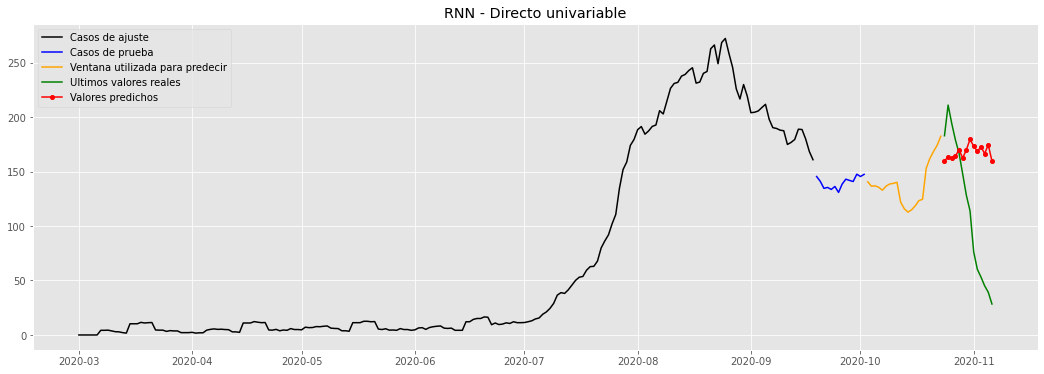

In [34]:
#@title 
#save the model
best_model.save(rnn_direct_dir+'rnn_direct_univariate_model.h5')
scalerfile = rnn_direct_dir+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

# plots
utils.plot_serie_with_next_window_prediction(best_model,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='RNN - Directo univariable')

In [35]:
#!zip -r Forecasting_COVID_BGA.zip Forecasting_COVID_BGA/*

  adding: Forecasting_COVID_BGA/BGA_COVID_ML_Prediction.ipynb (deflated 40%)
  adding: Forecasting_COVID_BGA/copy_Prediccion_COVID_bga.ipynb (deflated 68%)
  adding: Forecasting_COVID_BGA/data/ (stored 0%)
  adding: Forecasting_COVID_BGA/data/owid-covid-data.xlsx (deflated 17%)
  adding: Forecasting_COVID_BGA/dataset.py (deflated 72%)
  adding: Forecasting_COVID_BGA/EDA_COVID_19_time_series.ipynb (deflated 29%)
  adding: Forecasting_COVID_BGA/html/ (stored 0%)
  adding: Forecasting_COVID_BGA/html/EDA_COVID_19_time_series.html (deflated 41%)
  adding: Forecasting_COVID_BGA/LICENSE (deflated 66%)
  adding: Forecasting_COVID_BGA/models/ (stored 0%)
  adding: Forecasting_COVID_BGA/models/.ipynb_checkpoints/ (stored 0%)
  adding: Forecasting_COVID_BGA/models/xgboost.py (deflated 66%)
  adding: Forecasting_COVID_BGA/models/__pycache__/ (stored 0%)
  adding: Forecasting_COVID_BGA/models/__pycache__/xgboost.cpython-36.pyc (deflated 47%)
  adding: Forecasting_COVID_BGA/__pycache__/ (stored 0%)
